In [1]:
import numpy as np
import pandas as pd
import glob
import progressbar
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [2]:
def mag2fluxcal_snana(magpsf: float, sigmapsf: float):
    """ Conversion from magnitude to Fluxcal from SNANA manual
    Parameters
    ----------
    magpsf: float
        PSF-fit magnitude from ZTF.
    sigmapsf: float
        Error on PSF-fit magnitude from ZTF. 
    
    Returns
    ----------
    fluxcal: float
        Flux cal as used by SNANA
    fluxcal_err: float
        Absolute error on fluxcal (the derivative has a minus sign)
    """
    if magpsf is None:
        return None, None
    fluxcal = 10 ** (-0.4 * magpsf) * 10 ** (11)
    fluxcal_err = 9.21034 * 10 ** 10 * np.exp(-0.921034 * magpsf) * sigmapsf

    return fluxcal, fluxcal_err


def efficiency(label_pred: list, label_true: list, ia_flag=1):
    """Calculate efficiency.
    Parameters
    ----------
    label_pred: list
        Predicted labels
    label_true: list
        True labels
    ia_flag: int (optional)
        Flag used to identify Ia objects. Default is 1.
    Returns
    -------
    efficiency: float
       Fraction of correctly classified SN Ia.
    """

    cc_ia = sum([label_pred[i] == label_true[i] and label_true[i] == ia_flag for i in range(len(label_pred))])
    tot_ia = sum([label_true[i] == ia_flag for i in range(len(label_true))])

    return float(cc_ia) / tot_ia


def purity(label_pred: list, label_true: list, ia_flag=1):
    """ Calculate purity.
    Parameters
    ----------
    label_pred: list
        Predicted labels
    label_true: list
        True labels
    ia_flag: int (optional)
        Flag used to identify Ia objects. Default is 1.
    Returns
    -------
    Purity: float
        Fraction of true SN Ia in the final classified Ia sample.
    """

    cc_ia = sum([label_pred[i] == label_true[i] and label_true[i] == ia_flag for i in range(len(label_pred))])
    wr_nia = sum([label_pred[i] != label_true[i] and label_true[i] != ia_flag for i in range(len(label_pred))])

    if cc_ia + wr_nia > 0:
        return float(cc_ia) / (cc_ia + wr_nia)
    else:
        return 0

# Construct database from scratch with the same candid

In [6]:
# read Etienne's files
fname_etienne = '../../data/allAGN_100000.csv'
agn_etienne = pd.read_csv(fname_etienne)
agn_etienne_candid = agn_etienne[['candid']]

fname_etienne_noagn = '../../data/simbad_noAGN_1000000.csv'
noagn_etienne = pd.read_csv(fname_etienne_noagn)
noagn_etienne_candid = noagn_etienne[['candid']]

fname_etienne_tns = '../../data/tns_noAGN.csv'
tns_etienne = pd.read_csv(fname_etienne_tns)
tns_etienne_candid = tns_etienne[['candid']]

all_etienne_candid = pd.concat([agn_etienne_candid, noagn_etienne_candid, tns_etienne_candid], ignore_index=True)

In [7]:
# check total number of candid
all_etienne_candid.shape

(1111132, 1)

In [8]:
# check number of unique candid
np.unique(all_etienne_candid.values).shape

(1107481,)

In [9]:
# remove duplicates
etienne_candid = all_etienne_candid.drop_duplicates(subset=['candid'], keep=False)
etienne_candid.shape

(1103881, 1)

In [10]:
# Read zenodo data
orig_folder = '/media/emille/git/Fink/supernova_al/data/AL_data/'

orig_flist = glob.glob(orig_folder + '*.parquet')

In [11]:
data_list = []

for fname in progressbar.progressbar(np.array(orig_flist)):
    
    data_temp = pd.read_parquet(fname)
    
    flag_etienne = data_temp.candid.isin(etienne_candid.candid).astype(bool).values
    data_list.append(data_temp[flag_etienne]) 
        
data = pd.concat(data_list, ignore_index=True)

100% (34 of 34) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


In [12]:
# check size
data.shape

(1128467, 10)

In [13]:
# remove repeated
data.drop_duplicates(subset=['candid'], keep=False, inplace=True)

In [14]:
data.shape

(1079768, 10)

In [15]:
# separate in big classes, from Leoni et al., 2022

big_class = {}
big_class['multiple_object'] = ['EllipVar', 'Symbiotic*','SB*','DQHer', 
                                'Nova-like','EB*betLyr','AMHer','Nova','EB*Algol',
                                'EB*WUMa','CataclyV*',
                                  'DwarfNova','EB*']
big_class['star'] = ['brownD*','SG*','RCrB_Candidate', 'HV*', 'WR*', 'YellowSG*','gammaDor','RotV*alf2CVn',
                     'Erupt*RCrB','BlueStraggler','Eruptive*','V*?', 'Pulsar', 
                     'PulsV*bCep','low-mass*','post-AGB*', 'Pec*','pMS*','HotSubdwarf',
                     'PM*','*inNeb','pulsV*SX','RGB*','HB*','BYDra',
                       'PulsV*RVTau', 'BlueSG*','Irregular_V*','WD*','Ae*','RedSG*',
                     'AGB*','OH/IR','Be*','Cepheid','PulsV*delSct','RotV*','PulsV*',
                       'PulsV*WVir','S*','RSCVn','deltaCep','TTau*','Em*','Orion_V*',
                     'YSO','V*','C*','Mira','LPV*','Star','RRLyr']
big_class['AGN-like'] = ['LINER','Blazar','AGN','BLLac','QSO','Galaxy']
big_class['other_SN'] = ['SNIb-pec', 'SNIb/c','SNII-pec','SN', 'SNIbn','SNIc-BL','SNI',
                   'SNIb','SNIIb','SLSN-II','SNIIP','SLSN-I','SNIc','SNIIn','SNII',
                  'SN Ibn','SN Ic-BL','SN I', 'SN Ib','SN IIb','SN IIP', 'SN Ic','SN IIn',
                   'SN II', 'SN Icn', 'SNIcn', 'SN Ib/c','SN Ib-pec','SN IIL', 'SN II-pec']
big_class['other_TNS'] = ['Mdwarf', 'LBV','TDE','Other','CV','Varstar', 'M dwarf','LRN',
                          'FRB']
big_class['SNIa'] = ['Ia', 'SN Ia', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM', 
                'SN Ia-pec', 'SN Iax[02cx-like]']

# reverse it
class_dict = {}
for key in big_class.keys():
    for item in big_class[key]:
        class_dict[item] = key

In [16]:
# build big class column
big_class_list = []
small_class_list = []

for i in progressbar.progressbar(range(data.shape[0])):

    tns_class = data.iloc[i]['TNS']
    simbad_class = data.iloc[i]['cdsxmatch']
    
    found_class = False
    
    if tns_class in class_dict.keys():
        big_class_list.append(class_dict[tns_class])
        small_class_list.append(tns_class)
        found_class = True
        
    elif found_class == False and simbad_class in class_dict.keys():
        big_class_list.append(class_dict[simbad_class])
        small_class_list.append(simbad_class)
        found_class = True
        
    elif found_class == False:
        big_class_list.append(False)
        small_class_list.append(False)
        
big_class_array = np.array(big_class_list)

100% (1079768 of 1079768) |##############| Elapsed Time: 0:10:01 Time:  0:10:01


In [17]:
print('All labels added: ', big_class_array.shape[0])
print('    from which False: ', sum(np.array([item == False for item in big_class_list])))

All labels added:  1079768
    from which False:  0


In [18]:
data['big_class'] = big_class_list
data['small_class'] = small_class_list

In [19]:
unique_bigclass, pop = np.unique(np.array(big_class_list), return_counts=True)

In [20]:
pop_before_cuts = pd.DataFrame()
pop_before_cuts['bigclass'] = unique_bigclass
pop_before_cuts['population'] = pop
pop_before_cuts['perc'] = np.round(100 * pop/big_class_array.shape[0], 2)

In [21]:
pop_before_cuts

,bigclass,population,perc
0,AGN-like,96100,8.90
1,SNIa,6140,0.57
2,multiple_object,245944,22.78
3,other_SN,3819,0.35
4,other_TNS,830,0.08
5,star,726935,67.32


In [22]:
# impose  4 epochs per filter
filter_flag = []

for i in progressbar.progressbar(range(data.shape[0])):
    candid = data.iloc[i]['candid']

    filter_list = []
    for fil in range(1, 3):
        flag_temp = data.iloc[i]['cfid'] == fil
        filter_list.append(sum(flag_temp))

    filter_array = np.array(filter_list)

    if sum([item > 3 for item in filter_array]) == 2:
        filter_flag.append(True)
    else:
        filter_flag.append(False)
        
filter_flag = np.array(filter_flag)
data_cut = data[filter_flag]

100% (1079768 of 1079768) |##############| Elapsed Time: 0:22:11 Time:  0:22:11


In [23]:
data_cut.shape

(922310, 12)

In [24]:
unique_bigclass_cut, pop_cut = np.unique(data_cut['big_class'].values, return_counts=True)

In [25]:
pop_after_cuts = pd.DataFrame()
pop_after_cuts['bigclass'] = unique_bigclass_cut
pop_after_cuts['population'] = pop_cut
pop_after_cuts['perc'] = np.round(100 * pop_cut/data_cut.shape[0], 2)

In [26]:
pop_after_cuts

,bigclass,population,perc
0,AGN-like,89644,9.72
1,SNIa,5532,0.60
2,multiple_object,222601,24.14
3,other_SN,3421,0.37
4,other_TNS,712,0.08
5,star,600400,65.10


In [27]:
std = {}
max_flux = {}
npoints = {}
for i in range(1,3):
    std[i] = []
    max_flux[i] = []
    npoints[i] = []

    
for i in progressbar.progressbar(range(data_cut.shape[0])):

    for fil in range(1, 3):
        flag_temp = data_cut.iloc[i]['cfid'] == fil
        
        # convert mag to flux
        flux, fluxerr = mag2fluxcal_snana(data_cut.iloc[i]['cmagpsf'][flag_temp],
                                          data_cut.iloc[i]['csigmapsf'][flag_temp])
        
        # drop nans
        flux_clean = flux[~np.isnan(flux)]
        
        # calculate new features
        std[fil].append(np.std(flux_clean))
        max_flux[fil].append(np.max(flux_clean))
        npoints[fil].append(len(flux_clean))
        
data_cut['maxflux_g'] = max_flux[1]
data_cut['maxflux_r'] = max_flux[2]
data_cut['std_g'] = std[1]
data_cut['std_r'] = std[2]
data_cut['npoints_g'] = npoints[1]
data_cut['npoints_r'] = npoints[2]

100% (922310 of 922310) |################| Elapsed Time: 0:31:58 Time:  0:31:58
/media/emille/git/etienne/venv/etienne/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/media/emille/git/etienne/venv/etienne/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/media/emille/git/etienne/venv/etienne/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [28]:
size_flag = np.logical_and(data_cut['npoints_g'] > 3, data_cut['npoints_r'] > 3)

if sum(size_flag) < data_cut.shape[0]:
    data_cut_final = data_cut[size_flag]
    print('removed ', str(sum(~size_flag)))
else:
    data_cut_final = data_cut

removed  48989


In [29]:
data_cut_final.shape

(873321, 18)

In [30]:
data_cut_final.to_csv('data/emille_data.csv.gz', index=False)

# check parameter space

/media/emille/git/etienne/venv/etienne/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


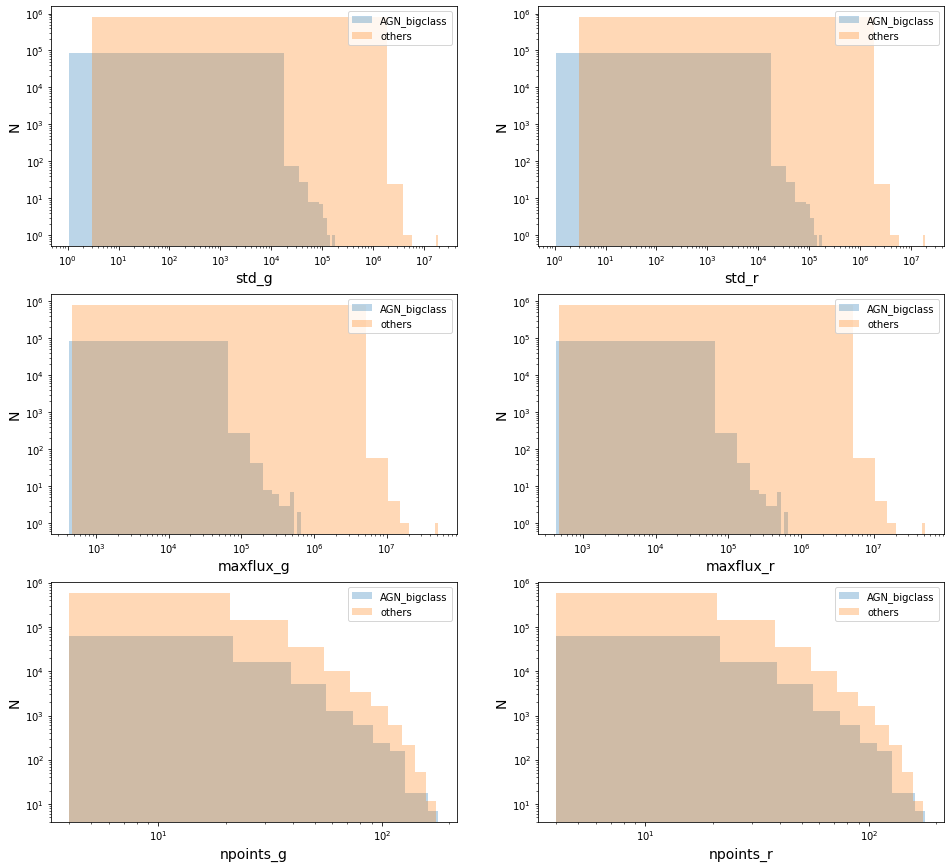

In [31]:
flag_AGN_bigclass = data_cut_final['big_class'] == 'AGN-like'
data_cut_final['AGN_bigclass'] = flag_AGN_bigclass.astype(int)

plt.figure(figsize=(16,15))

plt.subplot(3,2,1)
plt.hist(data_cut_final[flag_AGN_bigclass]['std_g'], label='AGN_bigclass', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag_AGN_bigclass]['std_g'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('std_g', fontsize=14)
plt.ylabel('N', fontsize=14)


plt.subplot(3,2,2)
plt.hist(data_cut_final[flag_AGN_bigclass]['std_r'], label='AGN_bigclass', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag_AGN_bigclass]['std_r'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('std_r', fontsize=14)
plt.ylabel('N', fontsize=14)

plt.subplot(3,2,3)
plt.hist(data_cut_final[flag_AGN_bigclass]['maxflux_g'], label='AGN_bigclass', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag_AGN_bigclass]['maxflux_g'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('maxflux_g', fontsize=14)
plt.ylabel('N', fontsize=14)


plt.subplot(3,2,4)
plt.hist(data_cut_final[flag_AGN_bigclass]['maxflux_r'], label='AGN_bigclass', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag_AGN_bigclass]['maxflux_r'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('maxflux_r', fontsize=14)
plt.ylabel('N', fontsize=14)

plt.subplot(3,2,5)
plt.hist(data_cut_final[flag_AGN_bigclass]['npoints_g'], label='AGN_bigclass', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag_AGN_bigclass]['npoints_g'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('npoints_g', fontsize=14)
plt.ylabel('N', fontsize=14)


plt.subplot(3,2,6)
plt.hist(data_cut_final[flag_AGN_bigclass]['npoints_r'], label='AGN_bigclass', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag_AGN_bigclass]['npoints_r'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('npoints_r', fontsize=14)
plt.ylabel('N', fontsize=14)

plt.show()

/media/emille/git/etienne/venv/etienne/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


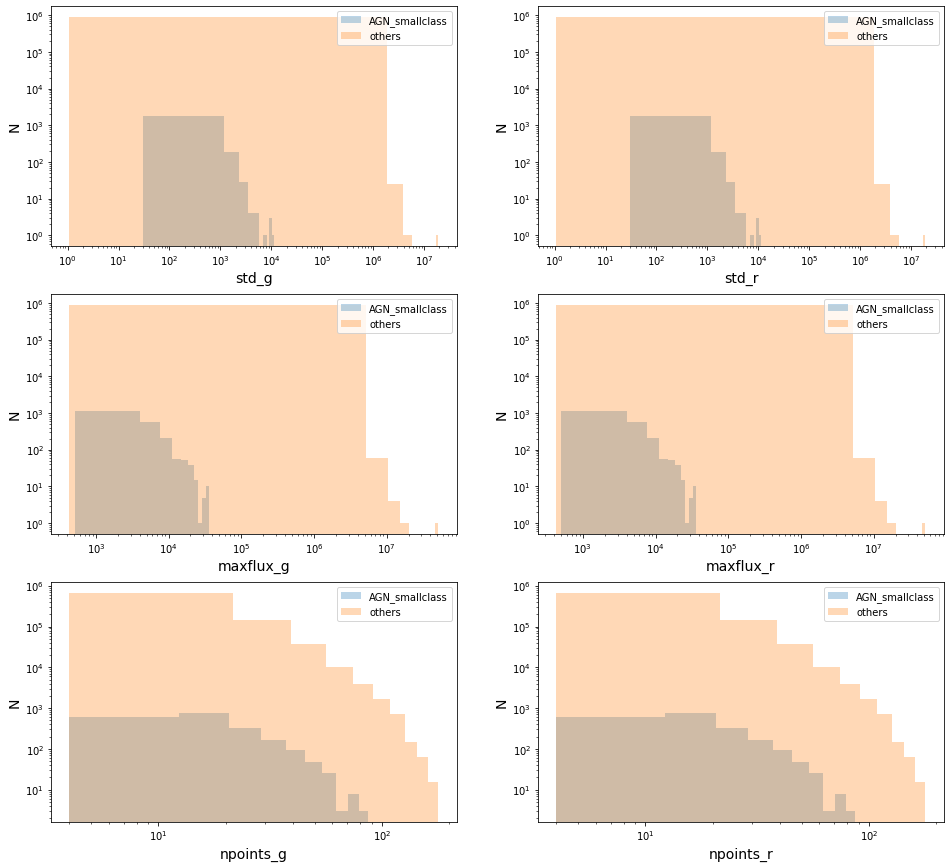

In [32]:
flag_AGN_smallclass = data_cut_final['small_class'] == 'AGN'
data_cut_final['AGN_smallclass'] = flag_AGN_smallclass.astype(int)

plt.figure(figsize=(16,15))

plt.subplot(3,2,1)
plt.hist(data_cut_final[flag_AGN_smallclass]['std_g'], label='AGN_smallclass', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag_AGN_smallclass]['std_g'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('std_g', fontsize=14)
plt.ylabel('N', fontsize=14)


plt.subplot(3,2,2)
plt.hist(data_cut_final[flag_AGN_smallclass]['std_r'], label='AGN_smallclass', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag_AGN_smallclass]['std_r'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('std_r', fontsize=14)
plt.ylabel('N', fontsize=14)

plt.subplot(3,2,3)
plt.hist(data_cut_final[flag_AGN_smallclass]['maxflux_g'], label='AGN_smallclass', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag_AGN_smallclass]['maxflux_g'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('maxflux_g', fontsize=14)
plt.ylabel('N', fontsize=14)


plt.subplot(3,2,4)
plt.hist(data_cut_final[flag_AGN_smallclass]['maxflux_r'], label='AGN_smallclass', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag_AGN_smallclass]['maxflux_r'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('maxflux_r', fontsize=14)
plt.ylabel('N', fontsize=14)

plt.subplot(3,2,5)
plt.hist(data_cut_final[flag_AGN_smallclass]['npoints_g'], label='AGN_smallclass', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag_AGN_smallclass]['npoints_g'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('npoints_g', fontsize=14)
plt.ylabel('N', fontsize=14)


plt.subplot(3,2,6)
plt.hist(data_cut_final[flag_AGN_smallclass]['npoints_r'], label='AGN_smallclass', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag_AGN_smallclass]['npoints_r'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('npoints_r', fontsize=14)
plt.ylabel('N', fontsize=14)

plt.show()

/media/emille/git/etienne/venv/etienne/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


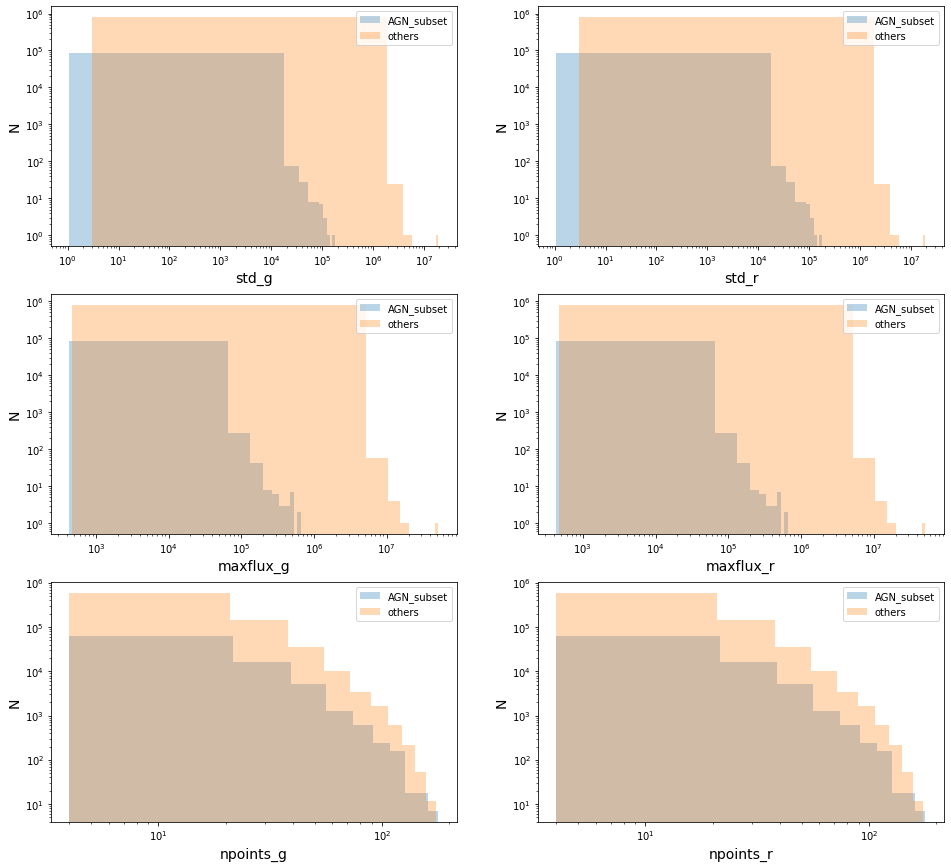

In [33]:
flags = {}
subset = ['LINER','Blazar','AGN','BLLac','QSO']
for i in range(len(subset)):
    flags[i] = data_cut_final['small_class'] == subset[i]
    
flag1 = np.logical_or(flags[0], flags[1])
flag2 = np.logical_or(flag1, flags[2])
flag3 = np.logical_or(flag2, flags[3])
flag4 = np.logical_or(flag3, flags[4])

data_cut_final['AGN_subset'] = flag4.astype(int)

plt.figure(figsize=(16,15))

plt.subplot(3,2,1)
plt.hist(data_cut_final[flag4]['std_g'], label='AGN_subset', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag4]['std_g'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('std_g', fontsize=14)
plt.ylabel('N', fontsize=14)


plt.subplot(3,2,2)
plt.hist(data_cut_final[flag4]['std_r'], label='AGN_subset', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag4]['std_r'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('std_r', fontsize=14)
plt.ylabel('N', fontsize=14)

plt.subplot(3,2,3)
plt.hist(data_cut_final[flag4]['maxflux_g'], label='AGN_subset', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag4]['maxflux_g'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('maxflux_g', fontsize=14)
plt.ylabel('N', fontsize=14)


plt.subplot(3,2,4)
plt.hist(data_cut_final[flag4]['maxflux_r'], label='AGN_subset', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag4]['maxflux_r'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('maxflux_r', fontsize=14)
plt.ylabel('N', fontsize=14)

plt.subplot(3,2,5)
plt.hist(data_cut_final[flag4]['npoints_g'], label='AGN_subset', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag4]['npoints_g'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('npoints_g', fontsize=14)
plt.ylabel('N', fontsize=14)


plt.subplot(3,2,6)
plt.hist(data_cut_final[flag4]['npoints_r'], label='AGN_subset', alpha=0.3, log=True)
plt.hist(data_cut_final[~flag4]['npoints_r'], label='others', alpha=0.3, log=True)
plt.xscale('log')
plt.legend()
plt.xlabel('npoints_r', fontsize=14)
plt.ylabel('N', fontsize=14)

plt.show()

In [34]:
sum(flag4)/flag4.shape[0]

0.09936094517365321

# Train a classifier

### small class

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data_cut_final[['std_r', 'std_g']], data_cut_final['AGN_smallclass'], 
                                                    test_size=0.5, random_state=42)

In [36]:
# use only std, subset sample
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
prob = clf.predict_proba(X_test)
predicted_labels = clf.predict(X_test)

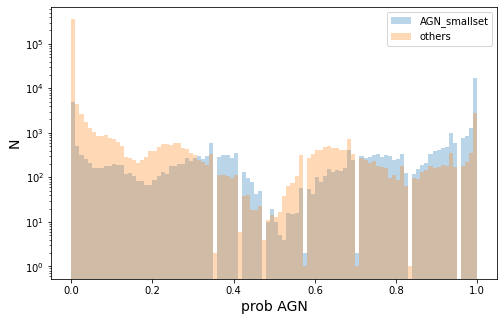

In [58]:
flag_pos = y_test == 1

plt.figure(figsize=(8,5))
plt.hist(prob[flag_pos][:,1], label='AGN_smallset', log=True, alpha=0.3, bins=100)
plt.hist(prob[~flag_pos][:,1], label='others', log=True, alpha=0.3, bins=100)
plt.xlabel('prob AGN', fontsize=14)
plt.ylabel('N', fontsize=14)
plt.legend()
plt.show()

In [38]:
clf.score(X_test, y_test)

0.99532589354213

In [39]:
# fraction of positive class in the data set
sum(y_test)/y_test.shape[0]

0.002349648812236495

In [40]:
efficiency(predicted_labels, y_test.values, ia_flag=1)

0.014619883040935672

In [41]:
purity(predicted_labels, y_test.values, ia_flag=1)

0.014354066985645933

### subset

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data_cut_final[['std_r', 'std_g']], data_cut_final['AGN_subset'], 
                                                    test_size=0.5, random_state=42)

In [43]:
# use only std, subset sample
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
prob = clf.predict_proba(X_test)
predicted_labels = clf.predict(X_test)

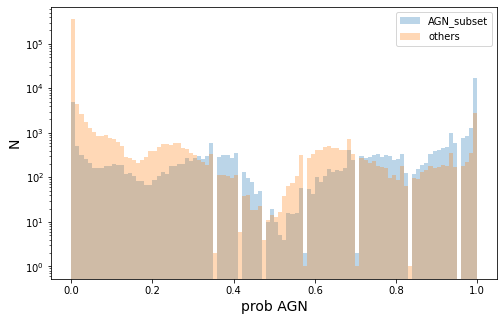

In [57]:
flag_pos = y_test == 1

plt.figure(figsize=(8,5))
plt.hist(prob[flag_pos][:,1], label='AGN_subset', log=True, alpha=0.3, bins=100)
plt.hist(prob[~flag_pos][:,1], label='others', log=True, alpha=0.3,bins=100)
plt.xlabel('prob AGN', fontsize=14)
plt.ylabel('N', fontsize=14)
plt.legend()
plt.show()

In [45]:
clf.score(X_test, y_test)

0.9384075976558475

In [46]:
# fraction of positive class in the data set
sum(y_test)/y_test.shape[0]

0.09963106391456988

In [47]:
efficiency(predicted_labels, y_test.values, ia_flag=1)

0.686886564762671

In [48]:
purity(predicted_labels, y_test.values, ia_flag=1)

0.6924413754750208

# big class

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data_cut_final[['std_r', 'std_g']], data_cut_final['AGN_bigclass'], 
                                                    test_size=0.5, random_state=42)

In [50]:
# use only std, bigset sample
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
prob = clf.predict_proba(X_test)
predicted_labels = clf.predict(X_test)

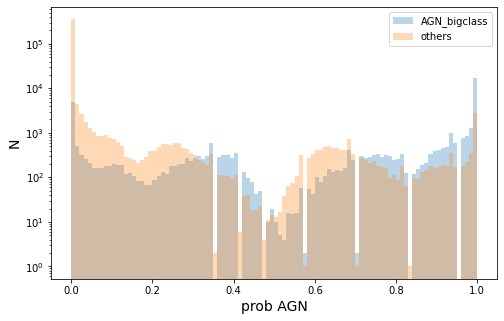

In [56]:
flag_pos = y_test == 1

plt.figure(figsize=(8,5))
plt.hist(prob[flag_pos][:,1], label='AGN_bigclass', log=True, alpha=0.3, bins=100)
plt.hist(prob[~flag_pos][:,1], label='others', log=True, alpha=0.3, bins=100)
plt.xlabel('prob AGN', fontsize=14)
plt.ylabel('N', fontsize=14)
plt.legend()
plt.show()

In [52]:
clf.score(X_test, y_test)

0.938412177867957

In [53]:
# fraction of positive class in the data set
sum(y_test)/y_test.shape[0]

0.09963335402062469

In [54]:
efficiency(predicted_labels, y_test.values, ia_flag=1)

0.6869397324506965

In [55]:
purity(predicted_labels, y_test.values, ia_flag=1)

0.6924627540026413